<a href="https://colab.research.google.com/github/BNN-UPC/ignnition/blob/ignnition-nightly/notebooks/shortest_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IGNNITION: Quick start tutorial

### **Problem**: Find the shortest path in graphs with a Graph Neural Network

Find more details on this quick-start tutorial at:
https://ignnition.org/doc/quick_tutorial/


---
# Prepare the environment

#### **Note**: Follow the instructions below to finish the installation

In [ ]:
#@title Installing libraries and load resources
#@markdown ####Hit **"enter"** to complete the installation of libraries
!add-apt-repository ppa:deadsnakes/ppa
!apt-get update
!apt-get install python3.7
!python -m pip install --upgrade pip
!pip install jupyter-client==6.1.5
!pip install ignnition==1.2.2
!pip install ipython-autotime



In [2]:
#@title Import libraries { form-width: "30%" }
import networkx as nx
import random
import json
from networkx.readwrite import json_graph
import os
import ignnition
%load_ext tensorboard
%load_ext autotime

time: 104 µs (started: 2021-09-29 16:40:02 +00:00)


In [ ]:
#@markdown #### Download three YAML files we will need after (train_options.yaml, model_description.yaml, global_variables.yaml)
# Download YAML files for this tutorial
!curl -O https://raw.githubusercontent.com/BNN-UPC/ignnition/ignnition-nightly/examples/Shortest_Path/train_options.yaml
!curl -O https://raw.githubusercontent.com/BNN-UPC/ignnition/ignnition-nightly/examples/Shortest_Path/global_variables.yaml
!curl -O https://raw.githubusercontent.com/BNN-UPC/ignnition/ignnition-nightly/examples/Shortest_Path/model_description.yaml




In [ ]:
#@title Generate the datasets (training and validation)
import os

def generate_random_graph(min_nodes, max_nodes, min_edge_weight, max_edge_weight, p):
    while True:
        # Create a random Erdos Renyi graph
        G = nx.erdos_renyi_graph(random.randint(min_nodes, max_nodes), p)
        complement = list(nx.k_edge_augmentation(G, k=1, partial=True))
        G.add_edges_from(complement)
        nx.set_node_attributes(G, 0, 'src-tgt')
        nx.set_node_attributes(G, 0, 'sp')
        nx.set_node_attributes(G, 'node', 'entity')

        # Assign randomly weights to graph edges
        for (u, v, w) in G.edges(data=True):
            w['weight'] = random.randint(min_edge_weight, max_edge_weight)

        # Select a source and target nodes to compute the shortest path
        src, tgt = random.sample(list(G.nodes), 2)

        G.nodes[src]['src-tgt'] = 1
        G.nodes[tgt]['src-tgt'] = 1

        # Compute all the shortest paths between source and target nodes
        try:
            shortest_paths = list(nx.all_shortest_paths(G, source=src, target=tgt,weight='weight'))
        except:
            shortest_paths = []
        # Check if there exists only one shortest path
        if len(shortest_paths) == 1:
            for node in shortest_paths[0]:
                G.nodes[node]['sp'] = 1
            return nx.DiGraph(G)

def generate_dataset(file_name, num_samples, min_nodes=5, max_nodes=15, min_edge_weight=1, max_edge_weight=10, p=0.3):
    samples = []
    for _ in range(num_samples):
        G = generate_random_graph(min_nodes, max_nodes, min_edge_weight, max_edge_weight, p)
        G.remove_nodes_from([node for node, degree in dict(G.degree()).items() if degree == 0])
        samples.append(json_graph.node_link_data(G))

    with open(file_name, "w") as f:
        json.dump(samples, f)

root_dir="./data"
if not os.path.exists(root_dir):
    os.makedirs(root_dir)
if not os.path.exists(root_dir+"/train"):
    os.makedirs(root_dir+"/train")
if not os.path.exists(root_dir + "/validation"):
    os.makedirs(root_dir + "/validation")
generate_dataset("./data/train/data.json", 20000)
generate_dataset("./data/validation/data.json", 1000)

---
# GNN model training

In [ ]:
#@title Remove all the models previously trained (CheckPoints)
#@markdown (It is not needed to execute this the first time)
! rm -r ./CheckPoint
! rm -r ./computational_graphs

In [ ]:
#@title Load TensorBoard to visualize the evolution of learning metrics along training
#@markdown **IMPORTANT NOTE**: Click on "settings" in the TensorBoard GUI and check the option "Reload data" to see the evolution in real time. Note you can set the reload time interval (in seconds).
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

dir="./CheckPoint"
if not os.path.exists(dir):
    os.makedirs(dir)
%tensorboard --logdir $dir

# Para finalizar instancias anteriores de TensorBoard
# !kill 2953
# !ps aux

In [7]:
#@title Run the training of your GNN model
#@markdown </u>**Note**</u>: You can stop the training whenever you want to continue making predictions below

import ignnition

model = ignnition.create_model(model_dir= './')
model.computational_graph()
model.train_and_validate()




Processing the described model...
---------------------------------------------------------------------------

Creating the GNN model...
---------------------------------------------------------------------------


Generating the computational graph... 
---------------------------------------------------------------------------

/content/computational_graphs/experiment_2021_09_29_16_40_27

Starting the training and validation process...
---------------------------------------------------------------------------

Number of devices: 1
Epoch 1/60
200/200 [==============================] - 18s 67ms/step - loss: 0.6197 - binary_accuracy: 0.6652 - precision: 0.3234 - recall: 0.0227 - val_loss: 0.4774 - val_binary_accuracy: 0.8521 - val_precision: 1.0000 - val_recall: 0.5970
Epoch 2/60
200/200 [==============================] - 11s 55ms/step - loss: 0.3923 - binary_accuracy: 0.8768 - precision: 0.9704 - recall: 0.6312 - val_loss: 0.2899 - val_binary_accuracy: 0.8872 - val_precision: 0.9361 -

---
# Make predictions
## (This can be only excuted once the training is finished or stopped)

In [ ]:
#@title Load functions to generate random graphs and print them
import os
import networkx as nx
import matplotlib.pyplot as plt
import json
from networkx.readwrite import json_graph
import ignnition
import numpy as np
import random
%load_ext autotime

def generate_random_graph(min_nodes, max_nodes, min_edge_weight, max_edge_weight, p):
    while True:
        # Create a random Erdos Renyi graph
        G = nx.erdos_renyi_graph(random.randint(min_nodes, max_nodes), p)
        complement = list(nx.k_edge_augmentation(G, k=1, partial=True))
        G.add_edges_from(complement)
        nx.set_node_attributes(G, 0, 'src-tgt')
        nx.set_node_attributes(G, 0, 'sp')
        nx.set_node_attributes(G, 'node', 'entity')

        # Assign randomly weights to graph edges
        for (u, v, w) in G.edges(data=True):
            w['weight'] = random.randint(min_edge_weight, max_edge_weight)

        # Select the source and target nodes to compute the shortest path
        src, tgt = random.sample(list(G.nodes), 2)

        G.nodes[src]['src-tgt'] = 1
        G.nodes[tgt]['src-tgt'] = 1

        # Compute all the shortest paths between source and target nodes
        try:
            shortest_paths = list(nx.all_shortest_paths(G, source=src, target=tgt,weight='weight'))
        except:
            shortest_paths = []
        # Check if there exists only one shortest path
        if len(shortest_paths) == 1:
            if len(shortest_paths[0])>=3 and len(shortest_paths[0])<=5:
                for node in shortest_paths[0]:
                    G.nodes[node]['sp'] = 1
                return shortest_paths[0], nx.DiGraph(G)

def print_graph_predictions(G, path, predictions,ax):
    predictions = np.array(predictions)
    node_border_colors = []
    links = []
    for i in range(len(path)-1):
        links.append([path[i], path[i+1]])
        links.append([path[i+1], path[i]])

    # Add colors to node borders for source and target nodes
    for node in G.nodes(data=True):
        if node[1]['src-tgt'] == 1:
            node_border_colors.append('red')
        else:
            node_border_colors.append('white')
    # Add colors for predictions [0,1]
    node_colors = predictions

    # Add colors for edges
    edge_colors = []
    for edge in G.edges(data=True):
        e=[edge[0],edge[1]]
        if e in links:
            edge_colors.append('red')
        else:
            edge_colors.append('black')
    pos= nx.shell_layout(G)
    vmin = node_colors.min()
    vmax = node_colors.max()
    vmin = 0
    vmax = 1
    cmap = plt.cm.coolwarm
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, cmap=cmap, vmin=vmin, vmax=vmax,
                           edgecolors=node_border_colors, linewidths=4, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=False, ax=ax, width=2)
    nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G, 'weight'), ax=ax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, ax=ax)

def print_graph_solution(G, path, predictions,ax, pred_th):
    predictions = np.array(predictions)
    node_colors = []
    node_border_colors = []
    links = []
    for i in range(len(path)-1):
        links.append([path[i], path[i+1]])
        links.append([path[i+1], path[i]])

    # Add colors on node borders for source and target nodes
    for node in G.nodes(data=True):
        if node[1]['src-tgt'] == 1:
            node_border_colors.append('red')
        else:
            node_border_colors.append('white')

    # Add colors for predictions Blue or Red
    cmap = plt.cm.get_cmap('coolwarm')
    dark_red = cmap(1.0)
    for p in predictions:
        if p >= pred_th:
            node_colors.append(dark_red)
        else:
            node_colors.append('blue')

    # Add colors for edges
    edge_colors = []
    for edge in G.edges(data=True):
        e=[edge[0],edge[1]]
        if e in links:
            edge_colors.append('red')
        else:
            edge_colors.append('black')
    pos= nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, edgecolors=node_border_colors, linewidths=4, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=False, ax=ax, width=2)
    nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G, 'weight'), ax=ax)

def print_input_graph(G, ax):
    node_colors = []
    node_border_colors = []

    # Add colors to node borders for source and target nodes
    for node in G.nodes(data=True):
        if node[1]['src-tgt'] == 1:
            node_border_colors.append('red')
        else:
            node_border_colors.append('white')

    pos= nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos=pos, edgecolors=node_border_colors, linewidths=4, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, arrows=False, ax=ax, width=2)
    nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G, 'weight'), ax=ax)


Starting to make the predictions...
---------------------------------------------------------



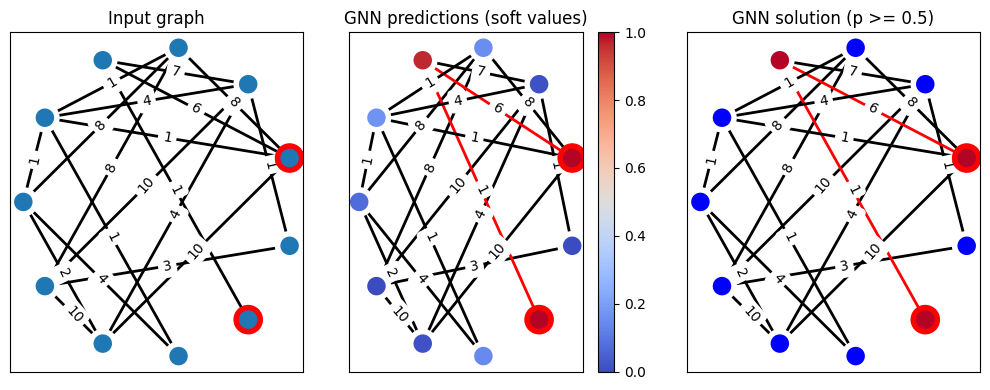

time: 2.04 s (started: 2021-09-29 16:48:34 +00:00)


In [10]:
#@title Make predictions on random graphs
#@markdown **NOTE**: IGNNITION will automatically load the latest trained model (CheckPoint) to make the predictions

dataset_samples = []
sh_path, G = generate_random_graph(min_nodes=8, max_nodes=12, min_edge_weight=1, max_edge_weight=10, p=0.3)
graph = G.to_undirected()
dataset_samples.append(json_graph.node_link_data(G))

# write prediction dataset
root_dir="./data"
if not os.path.exists(root_dir):
    os.makedirs(root_dir)
if not os.path.exists(root_dir+"/test"):
    os.makedirs(root_dir+"/test")
with open(root_dir+"/test/data.json", "w") as f:
    json.dump(dataset_samples, f)

# Make predictions
predictions = model.predict()

# Print the results
fig, axes = plt.subplots(nrows=1, ncols=3)
ax = axes.flatten()

# Print input graph
ax1 = ax[0]
ax1.set_title("Input graph")
print_input_graph(graph, ax1)

# Print graph with predictions (soft values)
ax1 = ax[1]
ax1.set_title("GNN predictions (soft values)")
print_graph_predictions(graph, sh_path, predictions[0], ax1)

# Print solution of the GNN
pred_th = 0.5
ax1 = ax[2]
ax1.set_title("GNN solution (p >= "+str(pred_th)+")")
print_graph_solution(graph, sh_path, predictions[0], ax1, pred_th)

# Show plot in full screen
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100
plt.tight_layout()
plt.show()


---
# Try to improve your GNN model

**Optional exercise**:

The previous training was executed with some parameters set by default, so the accuracy of the GNN model is far from optimal.

Here, we propose an alternative configuration that defines better training parameters for the GNN model.

For this, you can check and modify the following YAML files to configure your GNN model:
* /content/model_description.yaml -> GNN model description
* /content/train_options.yaml -> Configuration of training parameters

Try to define an optimizer with learning rate decay and set the number of samples and epochs adding the following lines in the train_options.yaml file:
```
optimizer:
  type: Adam
  learning_rate:  # define a schedule
    type: ExponentialDecay
    initial_learning_rate: 0.001
    decay_steps: 10000
    decay_rate: 0.5
...
batch_size: 1
epochs: 150
epoch_size: 200
```
Then, you can train a new model from scratch by executing al the code snippets from section "GNN model training"

Please note that the training process may take quite a long time depending on the machine where it is executed.

In this example, there are a total of 30,000 training samples:

1 sample/step * 200 steps/epoch * 150 epochs = 30.000 samples